# The Karplus-Strong Algorithm
<div align="right"><a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

The Karplus-Strong algorithm is a simple method to generate synthetic sounds with arbitrary pitch. In this notebook we will explore a few variations of the method to illustrate some basic notions of discrete-time signal processing.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython

In [2]:
plt.rcParams["figure.figsize"] = (14,4)

## 1. Introduction

A musical sound, to be considered a sound and not just noise, must produce in the listener the sensation of "pitch"; when we sing, for instance, the melodic line is carried by the vowels in the lyrics, and not by unvoiced sounds such as "s" or "t". Pitch in a musical note is determined by the periodic repetition of a pattern in the signal; the nuber of times per second that pattern repeats is called the *frequency* of the note, usually measured in Hertz that has dimension $s^{-1}$. 


In digital signal processing, all signals are just sequences of numbers, so there is no absolute notion of time; but, when we output a signal via a device such as a soundcard, a fundamental parameter is the number of samples per second that our device ingests: this is called the **sampling rate** of the system.

If a discrete-time signal contains a repeating pattern of $M$ samples, and if we feed the samples to a soundcard at a rate of $F_s$ samples per second, the perceived pitch will be equal to 

$$
    F_s \mbox{samples}/s \div M \mbox{samples} = \frac{F_s}{M} \mbox{Hz}
$$

In the rest of this notebook we will always use the following sampling rate:

In [3]:
Fs = 16000 # 16 KHz sampling rate

## 2. A basic generator

The simplest way to generate a pitched sound is to start with a $M$-sample pattern and build a long signal just by collating together as many copies of the pattern as we want: 

In [4]:
def periodizer(x, N):
    # given the initial buffer x, produce a length-N output
    #  by concatenating identical copies of the buffer
    y = x
    while len(y) < N:
        # keep appending until we reach or exceed the required length
        y = np.append(y, x)
    # trim the excess
    y = y[0:N+1]
    return y

As for the resulting pitch, if we initialize the periodizer algorithm with a vector of 50 values, the 50-sample pattern will fit $16000 / 50 = 320$ times in a second's worth of audio or, in other words, the resulting fundamantal frequency will be 320Hz, which corresponds roughly to a E4 on a piano (see later for the notation we use for musical pitches).

We still haven't talked about what to use as the initial values for the buffer. Perhaps surprisingly, not only can we use pretty much anything we want but using *random values* will produce some trumpet-like sounds. As a proof, consider this initial data set:

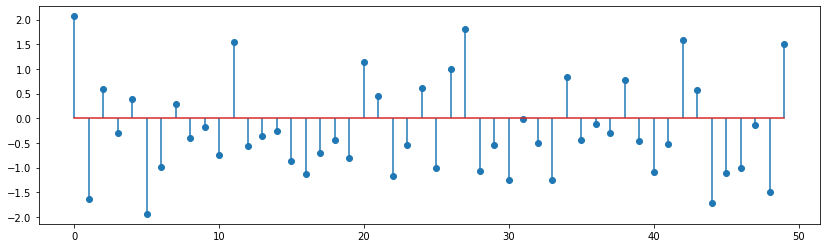

In [5]:
b = np.random.randn(50)
plt.stem(b, use_line_collection=True);

Let's now generate a 2-second audio clip:

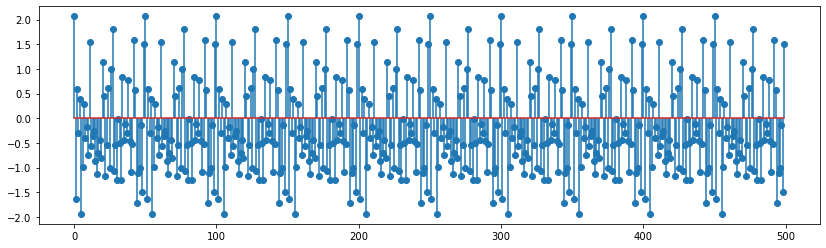

In [6]:
y = periodizer(b, Fs * 2)

# we can look at a few periods:
plt.stem(y[0:500], use_line_collection=True);

In [7]:
IPython.display.Audio(y, rate=Fs)

To move down an octave we need to halve the frequency, which correspond to just doubling the length of the initial buffer:

In [8]:
IPython.display.Audio(periodizer(np.random.rand(100), Fs * 2), rate=Fs)

## 3. Needs more DSP!

While the basic periodizer works, the Karplus-Strong algorithm is a bit more interesting. From the signal processing point of view, we can describe it via the following block diagram (neglect the factor $\alpha$ for a moment)

<img width="650" src="ks.png">

The output can be expressed as
$$
    y[n] = x[n] + y[n - M]
$$
assuming that the input is the finite-support signal
$$
x[n] = \begin{cases}
    0 & \mbox{for $n < 0$} \\
    b_n & \mbox{for $0 \le n < M$} \\
    0 & \mbox{for $n \ge M$}
  \end{cases}
$$

Let's implement the K-S algorithm as a signal processing loop

In [9]:
def KS_1(x, N):
    # length of the input
    M = len(x)
    # prepare the output
    y = np.zeros(N)
    # this is NOT an efficient implementation, but it shows the general principle
    # we assume zero initial conditions (y[n]=0 for n < 0)
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + (y[n-M] if n-M >= 0 else 0)
    return y

In [10]:
# it should still work
IPython.display.Audio(KS_1(np.random.rand(50), Fs * 2), rate=Fs)

By looking at block diagram we can see a simple modification that adds a lot of realism to the sound: by setting $\alpha$ to a value close to but less that one, we can introuce a decay in the note that produces sounds resembling those of a harpsichord:

$$
    y[n] = x[n] + \alpha y[n - M]
$$

In [11]:
def KS_2(x, N, alpha=0.99):
    M = len(x)
    y = np.zeros(N)
    # 
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + alpha * (y[n-M] if n-M >= 0 else 0)
    return y

If we now plot the resulting K-S output, we can see the decaying envelope:

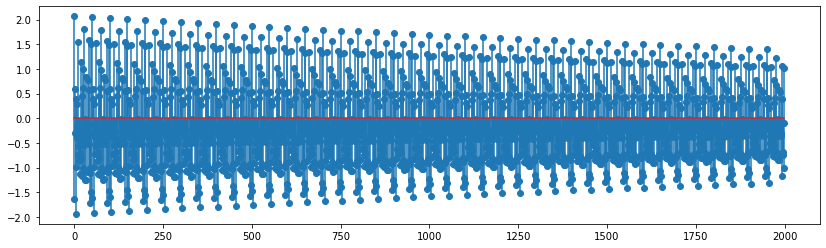

In [12]:
y = KS_2(b, Fs * 2)
plt.stem(y[0:2000], use_line_collection=True);

In [13]:
IPython.display.Audio(y, rate=Fs)

There is just one last detail (the devil's in the details, here as everywhere else). Consider the output of a dampened K-S loop; every time the initial buffer goes through the loop, it gets multiplied by $\alpha$ so that we can write

$$
  y[n] = \alpha^{\lfloor n/M \rfloor}x[n \mod M]
$$

(think about it and it will make sense). What that means is that the decay envelope is dependent on both $\alpha$ *and* $M$ or, in other words, the higher the pitch of the note, the faster its decay. For instance:

In [14]:
IPython.display.Audio(KS_2(np.random.rand(50), Fs * 2), rate=Fs)

In [15]:
IPython.display.Audio(KS_2(np.random.rand(10), Fs * 2), rate=Fs)

This is no good and therefore we need to modify the algorithm to ensure that, for a given value of $\alpha$, the decay rate is independent of pitch. This leads us to the final implementation of the K-S algorithm:

In [16]:
def KS(x, N, alpha=0.99):
    # we will adjust alpha so that all notes have a decay
    #  comparable to that of a buf len of 50 samples
    REF_LEN = 50
    M = len(x)
    a = alpha ** (float(M) / REF_LEN)
    y = np.zeros(N)
    # 
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + a * (y[n-M] if n-M >= 0 else 0)
    return y

In [17]:
IPython.display.Audio(KS(np.random.rand(50), Fs * 2), rate=Fs)

In [18]:
IPython.display.Audio(KS(np.random.rand(10), Fs * 2), rate=Fs)

## 4. Playing real music!

Let's now try to play a chord and, arguably, no guitar chord is as cool as the [opening chord of "A Hard Day's Night"](http://en.wikipedia.org/wiki/A_Hard_Day%27s_Night_%28song%29#Opening_chord), by The Beatles.

<img src="hdn.png" alt="Drawing" style="float: left; width: 200px; margin: 20px 30px;"/>

<audio controls src="hdn.mp3"></audio>

Much has been written about the chord (which, in fact, is made up of 2 guitars, one of which a 12-string, a piano and a bass) but to keep things simple, we will accept the most prevalent thesis which states that the notes are $D_3, F_3, G_3, F_4, A_4, C_5$ and $G_5$. To give it a "wider" feeling we will add another $D_2$ below. 

In Western music, where equal temperament is used, $A_4$ is the reference pitch at a frequency at 440Hz. All other notes can be computed using the formula $f(n) = A_4 \times 2^{n/12}$ where $n$ is the number of semitones between $A_4$ and the desired note. The exponent $n$ is positive if the note is above $A_4$ and negative otherwise.


Each note is generated using a separate Karplus-Strong algorithm. We try to mix the different "instruments" by assigning a different gain to each note.

In [19]:
def freq(note):
    # general purpose function to convert a note  in standard notation 
    #  to corresponding frequency
    if len(note) < 2 or len(note) > 3 or \
        note[0] < 'A' or note[0] > 'G':
        return 0
    if len(note) == 3:
        if note[1] == 'b':
            acc = -1
        elif note[1] == '#':
            acc = 1
        else:
            return 0
        octave = int(note[2])
    else:
        acc = 0
        octave = int(note[1])
    SEMITONES = {'A': 0, 'B': 2, 'C': -9, 'D': -7, 'E': -5, 'F': -4, 'G': -2}
    n = 12 * (octave - 4) + SEMITONES[note[0]] + acc
    f = 440 * (2 ** (float(n) / 12.0))
    #print note, f
    return f


def ks_chord(chord, N, alpha):
    y = np.zeros(N)
    # the chord is a dictionary: pitch => gain
    for note, gain in chord.items():
        # create an initial random-filled KS buffer the note
        x = np.random.randn(int(np.round(float(Fs) / freq(note))))
        y = y + gain * KS(x, N, alpha)
    return y  

In [20]:
# A Hard Day's Night's chord
hdn_chord = {
    'D2' : 2.2, 
    'D3' : 3.0, 
    'F3' : 1.0, 
    'G3' : 3.2, 
    'F4' : 1.0, 
    'A4' : 1.0, 
    'C5' : 1.0, 
    'G5' : 3.5,
}
    
IPython.display.Audio(ks_chord(hdn_chord, Fs * 4, 0.995), rate=Fs)

Close enough, no? (Check [here](https://upload.wikimedia.org/wikipedia/en/c/c4/A_Hard_Day's_Night_opening_chord.ogg)). You can now play around with other famous chords, try for instance the "Mystic Chord" by Scriabin, whose notes are $C_3, F^{\sharp}_3, B^{\flat}_3, E_4, A_4, D_5$.

## 5. Some food for thought

How would you describe what's happening here?

In [23]:
a = np.random.rand(100)
b = np.random.rand(80)
c = np.concatenate((a, a, a, a)) + np.concatenate((b, b, b, b, b))

IPython.display.Audio(KS_1(c, Fs * 2), rate=Fs)

# ---------------------------------




### Did you like this Notebook?
Yes, no, maybe? Why don't you give us some feedback using the completely anonymous form below? Thank you!

In [22]:
from IPython.display import IFrame
IFrame('https://www.surveymonkey.com/r/NOTOSURVEY?notebook_set=COM303&notebook_id=KS', 600, 800)